In [2]:
from __future__ import division
import numpy as np
import scipy.signal
import os
import scipy.io as sci_io
import matplotlib.pyplot as plt
import nitime.algorithms as tsa
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import warnings
import math
import neo as ne
import scipy.signal as signal
from pathlib import Path
warnings.filterwarnings('ignore')
import quantities as pq

C:\Users\CSC\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Functions definition

In [3]:
def dB(x, out=None):
    if out is None:
        return 10 * np.log10(x)
    else:
        np.log10(x, out)
        np.multiply(out, 10, out)

In [4]:
def mtem(i, j, dt):
    """
    multitaper estimation method
    Input:
    i      first time series
    j      second time series

    Output:
    fki    power spectral density i
    fkj    power spectral density j
    cij    cross-spectral density ij
    coh    coherence
    ph     phase spectrum between ij at input freq

    """
    # print('i size', i.shape)
    # print('j size', j.shape)

#     import nitime.algorithms as tsa
#     import numpy as np
    # apply multi taper cross spectral density from nitime module
    f, pcsd_est = tsa.multi_taper_csd(np.vstack([i, j]), Fs=1 / dt, low_bias=True, adaptive=True, sides='onesided')

    # output is MxMxN matrix, extract the psd and csd
    fki = pcsd_est.diagonal().T[0]
    fkj = pcsd_est.diagonal().T[1]
    cij = pcsd_est.diagonal(+1).T.ravel()

    # using complex argument of cxy extract phase component
    ph = np.angle(cij)

    # calculate coherence using csd and psd
    coh = np.abs(cij) ** 2 / (fki * fkj)

    return f, fki, fkj, cij, ph, coh

In [5]:
def buffer_ale(x, n, p):

    import numpy as np

    a = len(np.arange(0, np.shape(x)[0] - n, p - 1))
#     a = int(np.shape(x)[0] / (n - p))
    b = (a, n)
    buf = np.zeros(b)

    a = 0;
    for i in range(0, np.shape(x)[0] - n, p - 1):
        buf[a, :] = x[i:i + n]
        a = a + 1;

    return buf

In [6]:
def cross_spectrum_mtem(signals, time):

#     import numpy as np
#     from buffer_ale import buffer_ale
#     from mtem import mtem
    l_buf = buffer_ale(signals[0], 37, 18)
#     l_buf = buffer_ale(signals[0], 55, 28)
    n = np.shape(l_buf)
    ph_matrix = np.zeros([32, 32, n[0]])
    Cross_spect = np.zeros([32, 32, n[0]],dtype=complex)

    for ch1 in range(0, 32):
        for ch2 in range(0, 32):
#             print(ch1, ch2)
            s1 = signals[ch1]
            s2 = signals[ch2]
            t = time[1]
            dt = t[2] - t[1]

#             s1_buf = buffer_ale(s1, 55, 28)  # windows of 0.1s with 50% overlap
#             s2_buf = buffer_ale(s2, 55, 28)
            
            s1_buf = buffer_ale(s1, 37, 18)  # windows of 0.07s with 50% overlap
            s2_buf = buffer_ale(s2, 37, 18)
            
            np.shape(s1_buf)

            # cs = np.nan
            # cs= np.empty([np.shape(s1_buf)[0], 28], dtype=complex)
            cs = []
            ph_f = []
            # computing the cross-spectrum
            for i, seg in enumerate(s1_buf):
                (f, fki, fkj, csd, ph, coh) = mtem(s1_buf[i, :], s2_buf[i, :], dt)
                # (csd[i, :], f) = mlab.csd(s1_buf[i, :], s2_buf[i, :], NFFT=55, Fs=1. / dt, detrend=mlab.detrend_none,
                #                           window=mlab.window_hanning, noverlap=0, pad_to=100,
                #                           sides='default', scale_by_freq=False)
            # (f, fki, fkj, csd, ph, coh) = mtem(s1_buf[1, :], s2_buf[1, :], dt)
                if i==0:
                    cs=csd
                    ph_f=ph
                else:
                    cs = np.vstack((cs, csd))
                    ph_f=np.vstack((ph_f, ph))

            idx1=[k for k, val in enumerate(f) if val>32]
            Lfreq=f[idx1[0]]
            idx2=[k for k, val in enumerate(f) if val<110]
            Hfreq=f[idx2[-1]]

            gamma = (np.shape(cs)[0], 1)
            gamma_csd = np.zeros(gamma, dtype=complex)
            angle = np.zeros(gamma)

            for i in range(0, np.shape(cs)[0]):
                gamma_csd[i] = np.mean(cs[i, idx1[0]:idx2[-1]]) #all gamma 32:100
                angle[i] = np.angle(gamma_csd[i], deg=False)

            a = angle
            spec=gamma_csd
            # print(np.shape(a))
            # aa = np.reshape(a, (2041))
            aa = np.reshape(a, (n[0]))
            crossSpect=np.reshape(spec, (n[0]))
            # print(np.shape(aa))
            Cross_spect[ch1, ch2, :] = crossSpect
            ph_matrix[ch1, ch2, :] = aa
        # print(ph_matrix[0,0,:])

    return (f,Lfreq,Hfreq, ph_matrix, Cross_spect)

# Data Collection and Preprocessing

In [7]:
DataDir = 'C:/ALESSANDRA/PROPAGATION/APP/Data/161208_APP_WT/161208_rec11_Propagation_000'
# DataDir = './frontalD300'

File1 = DataDir + '/TimePeriod.mat'
mat_contents = sci_io.loadmat(File1)

DirFile = DataDir + '/161208_rec11_Propagation_000.smr'
SMRfile = ne.io.Spike2IO(DirFile)
Block = SMRfile.read()[0] # read the entire file = a Block
Seg = Block.segments[0] # child access = equivalent to trials or recordings contained in Block

AnalogSignalsArray_temp = Seg.analogsignals # array of 32 = n of channels analog signals

File = DataDir + '/Settings.mat';
mat_contents = sci_io.loadmat(File)
hem_arr = mat_contents['Hem']
Settings = {'Hem': hem_arr[0]}

ele2VeleR=[27, 18,  28, 19, 10,  29, 20, 11,  30, 21, 12, 4,  31, 22, 13, 5,  32, 23, 14, 6,  33, 24, 15, 7, 3,  34, 25, 16, 8, 26, 17, 9]
ele2VeleL=[10, 19, 9, 18, 27, 8, 17, 26, 7, 16, 25, 33, 6, 15, 24, 32, 5, 14, 23, 31, 4, 13, 22, 30, 34, 3, 12, 21, 29, 11, 20, 28]

if Settings['Hem'] == 'HR':
    indice = ele2VeleR;
else:
    if Settings['Hem'] == 'HL':
        indice = ele2VeleL;

Names = [o.name for o in AnalogSignalsArray_temp]

AnalogSignalsArray = []
for j in range(len(AnalogSignalsArray_temp)):
    i_ch = [i for i, nam in enumerate(Names) if 'E' + str(indice[j]).zfill(2) in nam]
    i_ch = i_ch[0]

    AnalogSignalsArray.append(AnalogSignalsArray_temp[i_ch])


RawSignal=AnalogSignalsArray

# for i in range(len(AnalogSignalsArray_temp)):
#     pos=[(np.where((AnalogSignalsArray_temp[i].times > mat_contents['TimePeriod'][0,0]) & (AnalogSignalsArray_temp[i].times < mat_contents['TimePeriod'][0,1])))]
#     RawSignal.append(AnalogSignalsArray_temp[i][pos[0][0].item(0):pos[0][0].item(-1)+1])


# Trial Average with UP onset

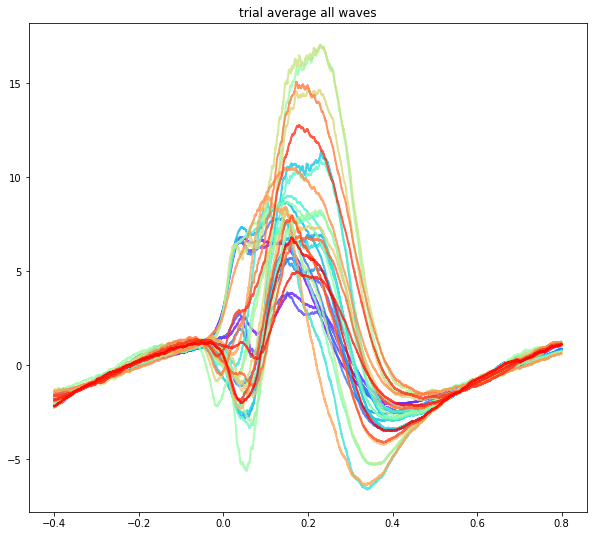

In [66]:
AnalysisDir='C:/ALESSANDRA/PROPAGATION/PhasePropagation/Analysis/161208_2'
File2 = AnalysisDir + '/WaveTime.mat'
mat_contents = sci_io.loadmat(File2)
WaveTime = np.squeeze(mat_contents['WaveTime'])
Ptimes=WaveTime*pq.s;
TimeWindow = [-0.4, 0.8]

TimeWindow_s = TimeWindow*pq.s;

sig = RawSignal[0]
Ts = np.mean(np.diff(sig.times))
nSamps = int((TimeWindow_s[1]-TimeWindow_s[0])/Ts)
t = np.arange(nSamps)*Ts + TimeWindow_s[0]

NormStimAvSigArray = []
for i, sig in enumerate(RawSignal):
    avg = np.array([])
    for et in Ptimes:
        start = et + TimeWindow_s[0]
        stop = et + TimeWindow_s[1]
        sl = sig.time_slice(start, stop)
        try:
            avg = np.hstack([avg, sl[:nSamps]]) if avg.size else sl[:nSamps]  # y voy acumulando
        except:
            print('Error', nSamps, et, avg.shape, sl.shape)
            break

    # Average
    MeanT = np.mean(avg, axis=1)
    MySignal = ne.AnalogSignal(MeanT * pq.microvolt, sampling_period=Ts, t_start=t[0], name=sig.name + "stim_av")

    # Normalization with respect to the BL
    ndxBaseline = (t < 0).nonzero()
    MySignal_normBL = (MySignal - np.mean(MySignal.take([ndxBaseline]))) / np.std(MySignal.take([ndxBaseline]))
    MySignal_normBL.name = sig.name + "norm_stim_av"

    # Save signal in array
    NormStimAvSigArray.append(MySignal_normBL)

# Dibujo LFP_trigAv
Fig = plt.figure(figsize=(10, 9))

from matplotlib.pyplot import cm
color=cm.rainbow(np.linspace(0,1,32))

# for sig in NormStimAvSigArray:
#     plt.plot(t, sig[:nSamps], 'k-', alpha=0.3, figure=Fig, linewidth=2)  # dibujo
    
    
for sig, c in zip(NormStimAvSigArray, color):
    plt.plot(t, sig[:nSamps], c=c, alpha=0.8, figure=Fig, linewidth=2)  # dibujo
    plt.title('trial average all waves')    

In [67]:
#downsampling to compute phase
sg = []
ds_sg = []
ds_sg_rs = []
tm = []
ds_tm = []

downFs = 500;
for i in range(len(NormStimAvSigArray)):
    sg.append(np.array((NormStimAvSigArray[i] - np.mean(NormStimAvSigArray[i])) / np.std(NormStimAvSigArray[i]))) #raw signal
    ds_sg.append(signal.decimate(sg[i], int(RawSignal[i].sampling_rate / downFs), n=30, axis=0, zero_phase=True,
                                     ftype='fir')) #downsampled signal
    ds_sg_rs.append(ds_sg[i].reshape(len(ds_sg[i]))) #downsampled reshaped signal

    tm.append(np.array(t))
    ds_tm.append(signal.decimate(tm[i], int(RawSignal[i].sampling_rate / downFs), axis=0, zero_phase=True))

In [68]:
(f,Lfreq,Hfreq, Phase_mtem, cross_spect_mtem) = cross_spectrum_mtem(ds_sg_rs, ds_tm)

In [21]:
np.shape(Phase_mtem)

(32, 32, 40)

In [13]:
phm = np.empty([np.shape(Phase_mtem[0])[1], 32, 32])
for t in range(0, np.shape(Phase_mtem[0])[1]):
    for ch1 in range(0, 32):
        for ch2 in range(0, 32):
            phm[t, ch1, ch2] = (Phase_mtem[ch1, ch2, t])

ph_tri = np.empty([np.shape(Phase_mtem[0])[1], 32, 32])
ph_mean = np.empty([np.shape(Phase_mtem[0])[1], 32])

for t in range(0, np.shape(Phase_mtem[0])[1]):  # extractring the upper triangle of each matrix
    ph_tri[t, :, :] = np.triu(phm[t, :, :])
    ph_mean[t, :] = np.mean(phm[t, :, :], axis=1)

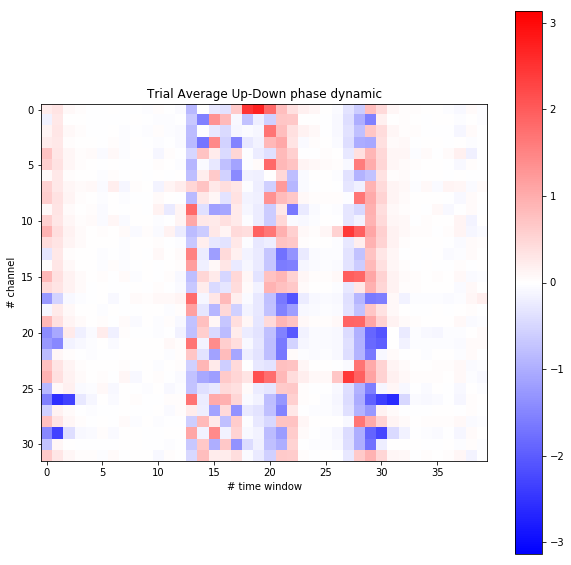

In [14]:
plt.figure(figsize=(10,10))
ax=plt.imshow(ph_mean.T,  cmap='bwr')
plt.title('Trial Average Up-Down phase dynamic')
plt.ylabel('# channel')
plt.xlabel('# time window')
ax.set_clim(-3.14,3.14)
plt.colorbar(ax)

Text(0.5,0,'# time window')

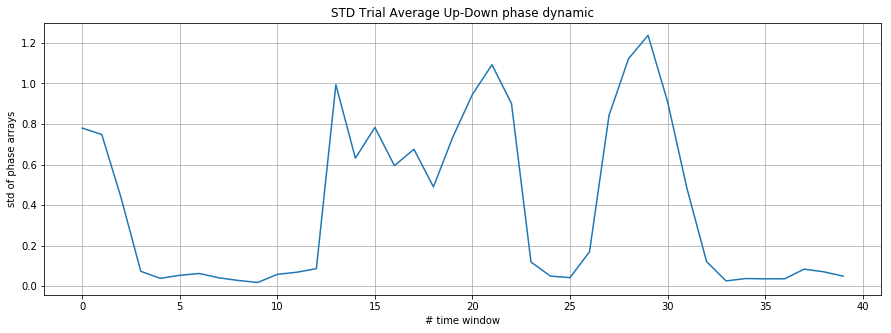

In [15]:
ph_std = np.empty(np.shape(ph_mean)[0])
for t in range(0, np.shape(ph_mean)[0]):
            ph_std[t] = np.std(ph_mean[t])
plt.figure(figsize=(15,5))
plt.grid()
ax=plt.plot(ph_std)
plt.title('STD Trial Average Up-Down phase dynamic')
plt.ylabel('std of phase arrays')
plt.xlabel('# time window')
# plt.xlim(0,100)     

In [16]:
def vec2grid(vec):
    # with the order of acquisition of LH (10,19,9,18,27...11,20,28)
    import numpy as np

    am = vec
    Grid = np.zeros((9, 5,))
    Grid[8, 0] = am[0]
    Grid[8, 1] = am[1]
    Grid[7, 0] = am[2]
    Grid[7, 1] = am[3]
    Grid[7, 2] = am[4]
    Grid[6, 0] = am[5]
    Grid[6, 1] = am[6]
    Grid[6, 2] = am[7]
    Grid[5, 0] = am[8]
    Grid[5, 1] = am[9]
    Grid[5, 2] = am[10]
    Grid[5, 3] = am[11]
    Grid[4, 0] = am[12]
    Grid[4, 1] = am[13]
    Grid[4, 2] = am[14]
    Grid[4, 3] = am[15]
    Grid[3, 0] = am[16]
    Grid[3, 1] = am[17]
    Grid[3, 2] = am[18]
    Grid[3, 3] = am[19]
    Grid[2, 0] = am[20]
    Grid[2, 1] = am[21]
    Grid[2, 2] = am[22]
    Grid[2, 3] = am[23]
    Grid[2, 4] = am[24]
    Grid[1, 0] = am[25]
    Grid[1, 1] = am[26]
    Grid[1, 2] = am[27]
    Grid[1, 3] = am[28]
    Grid[0, 1] = am[29]
    Grid[0, 2] = am[30]
    Grid[0, 3] = am[31]

    return Grid

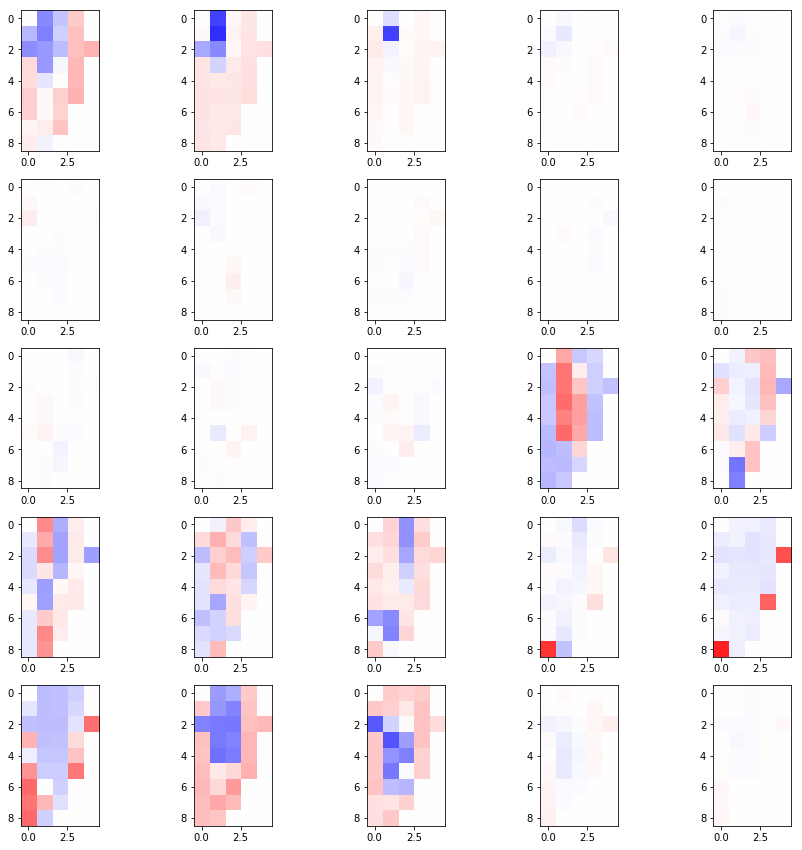

In [17]:
### plot phase grid at each time step
plt.figure(figsize=(15,15))

ax = plt.subplot(551)
Grid=vec2grid(ph_mean[0])
# ax.set_title('phase relation at t=8')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(552)
Grid=vec2grid(ph_mean[1])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(553)
Grid=vec2grid(ph_mean[2])
# ax.set_title('phase relation at t=8')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(554)
Grid=vec2grid(ph_mean[3])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(555)
Grid=vec2grid(ph_mean[4])
# ax.set_title('phase relation at t=8')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(556)
Grid=vec2grid(ph_mean[5])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(557)
Grid=vec2grid(ph_mean[6])
# ax.set_title('phase relation at t=8')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(558)
Grid=vec2grid(ph_mean[7])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(559)
Grid=vec2grid(ph_mean[8])
# ax.set_title('phase relation at t=8')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,10)
Grid=vec2grid(ph_mean[9])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,11)
Grid=vec2grid(ph_mean[10])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,12)
Grid=vec2grid(ph_mean[11])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,13)
Grid=vec2grid(ph_mean[12])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,14)
Grid=vec2grid(ph_mean[13])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,15)
Grid=vec2grid(ph_mean[14])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,16)
Grid=vec2grid(ph_mean[15])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,17)
Grid=vec2grid(ph_mean[16])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,18)
Grid=vec2grid(ph_mean[17])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,19)
Grid=vec2grid(ph_mean[18])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,20)
Grid=vec2grid(ph_mean[19])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,21)
Grid=vec2grid(ph_mean[20])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,22)
Grid=vec2grid(ph_mean[21])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,23)
Grid=vec2grid(ph_mean[22])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,24)
Grid=vec2grid(ph_mean[23])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

ax = plt.subplot(5,5,25)
Grid=vec2grid(ph_mean[24])
# ax.set_title('phase relation at t=9')
# ax.set_xlabel('# channel')
# ax.set_ylabel('# channel')
im = ax.imshow(Grid, cmap='bwr')
im.set_clim(-3.14,3.14)

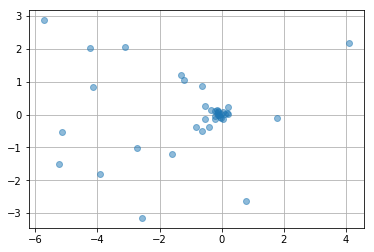

In [18]:
cov_numpy = np.ma.cov(ph_mean, rowvar=0, allow_masked=True, ddof=1).data

[U, S, V] = np.linalg.svd(cov_numpy)

PC_variance = S**2/(np.shape(ph_mean)[1]-1)
cum_var = np.cumsum(PC_variance)/np.sum(PC_variance)*100
n_components =16

V = V.T
Vk = V[:, :n_components]
# Vk = V
# TLM_all=np.asarray(TLM_all)
X_pca = ph_mean.dot(Vk)


plt.figure(1)
plt.plot(X_pca[:, 0], X_pca[:, 1], 'o', alpha=0.5)
plt.grid()
plt.hold(False)

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

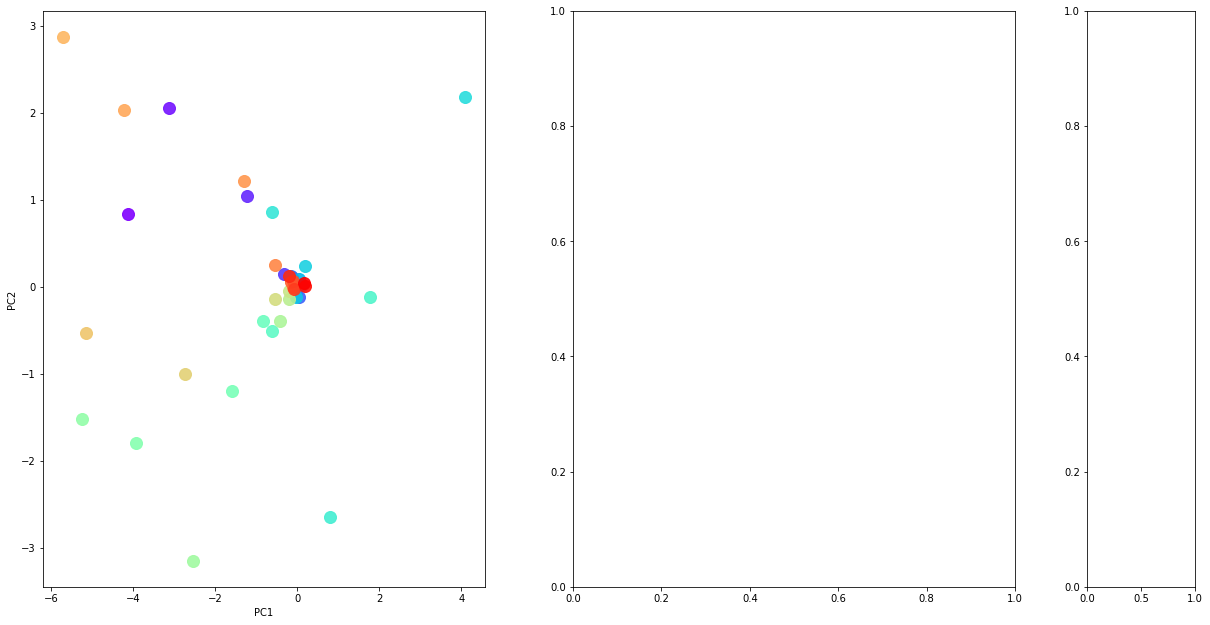

In [30]:

Fig = plt.figure(figsize=(20, 10))
color=cm.rainbow(np.linspace(0,1,len(ph_mean)))

plt.subplot(121)
i=0
for sig, c in zip(ph_mean, color):
    plt.plot(X_pca[i, 0], X_pca[i, 1],'o',c=c, alpha=0.9,markersize=12, figure=Fig)  # dibujo
    plt.hold(True)
    i=i+1
    plt.xlabel('PC1')
    plt.ylabel('PC2')
#     plt.title('trial average of waves in cluster 2')
plt.subplot(122)
# ale=np.reshape(color[:,0],[40,1])
# plt.imshow(1,cmap=cm.rainbow,)

plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(cax=color)
plt.show()

In [25]:
len(ph_mean)

40

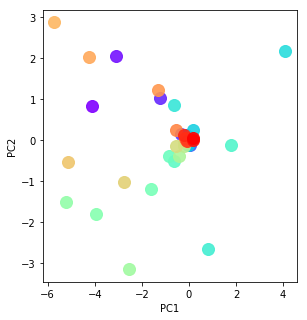

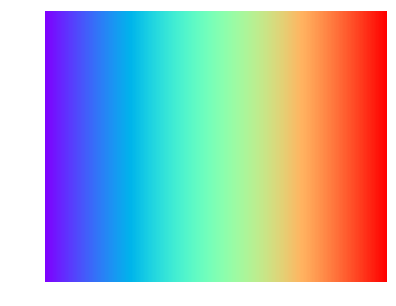

In [65]:


Fig = plt.figure(figsize=(10, 5))
color=cm.rainbow(np.linspace(0,1,len(ph_mean)))

plt.subplot(121)
i=0
for sig, c in zip(ph_mean, color):
    plt.plot(X_pca[i, 0], X_pca[i, 1],'o',c=c, alpha=0.9,markersize=12, figure=Fig)  # dibujo
    plt.hold(True)
    i=i+1
    plt.xlabel('PC1')
    plt.ylabel('PC2')
#     plt.title('trial average of waves in cluster 2')

from colorspacious import cspace_converter
from collections import OrderedDict

cmaps = OrderedDict()

cmaps['Miscellaneous'] = [ 'rainbow']
# cmaps['Miscellaneous'] = [ 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar']
nrows = max(len(cmap_list) for cmap_category, cmap_list in cmaps.items())
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(cmap_category, cmap_list, nrows):
    fig, axes = plt.subplots(nrows=nrows)
    fig.subplots_adjust(top=0.95, bottom=0.01, left=0.2, right=0.99)
#     axes[0].set_title(cmap_category + ' colormaps', fontsize=14)

    for name in zip(cmap_list):
        axes.imshow(gradient, aspect='auto', cmap=plt.get_cmap('rainbow'))
        pos = list(axes.get_position().bounds)
        x_text = pos[0] - 0.01
        y_text = pos[1] + pos[3]/2.
        axes.set_axis_off()


for cmap_category, cmap_list in cmaps.items():
    plot_color_gradients(cmap_category, cmap_list, nrows)

plt.show()